## Setup

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# External modules
import ast
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/isuelogit


In [3]:
# Internal modules
from src import isuelogit as isl

In [4]:
# Seed
_SEED = 2022

## Read network data from Fresno

In [5]:
network_name = 'Fresno'

# To write estimation report and set seed for all algorithms involving some randomness  
estimation_reporter = isl.writer.Reporter(
    folderpath = isl.config.dirs['output_folder'] + 'estimations/' + network_name, seed = _SEED)

# Reader of geospatial and spatio-temporal data
data_reader = isl.etl.DataReader(network_key=network_name)

# First Tuesday of October, 2019
data_reader.select_period(date='2019-10-01', hour=16)

# Read nodes data
nodes_df = pd.read_csv(isl.dirs['input_folder'] + '/network-data/nodes/'  + 'fresno-nodes-data.csv')

# Read spatiotemporal link data
links_df = pd.read_csv(
    isl.dirs['input_folder'] + 'network-data/links/' + str(data_reader.options['selected_date'])+ '-fresno-link-data.csv',
    converters={"link_key": ast.literal_eval,"pems_id": ast.literal_eval})


Selected date is 2019-10-01, Tuesday at 16:00


## Build network

In [6]:
network_generator = isl.factory.NetworkGenerator()

A = network_generator.generate_adjacency_matrix(links_keys=list(links_df['link_key'].values))

fresno_network = \
    network_generator.build_fresno_network(A=A, links_df=links_df, nodes_df=nodes_df, network_name= network_name)


Creating Fresno network

Nodes: 1789, Links: 2413


### OD matrix

In [7]:
network_generator.read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


### Paths

In [8]:
paths_generator = isl.factory.PathsGenerator()

# # Generate and Load paths in network
# paths_generator.load_k_shortest_paths(network = fresno_network, k=3)

# Read and load paths in network
paths_generator.read_paths(network=fresno_network, update_incidence_matrices=True)

13905 paths were read in 12.7[s]              

13905 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 13905) generated in 21.4[s] 

Matrix M (6970, 13905) generated in 5.6[s]% 

Matrix C (13905, 13905) generated in 2.6[s]



### Link performance functions

In [9]:
bpr_parameters_df = pd.DataFrame({'link_key': links_df['link_key'],
                                  'alpha': links_df['alpha'],
                                  'beta': links_df['beta'],
                                  'tf': links_df['tf_inrix'],
                                  #'tf': links_df['tf'],
                                  'k': pd.to_numeric(links_df['k'], errors='coerce', downcast='float')
                                  })

# Normalize free flow travel time between 0 and 1
bpr_parameters_df['tf'] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(np.array(bpr_parameters_df['tf']).reshape(-1, 1)))

fresno_network.set_bpr_functions(bprdata=bpr_parameters_df)

### Feature Engineering

In [10]:
fresno_network.load_features_data(links_df, link_key = 'link_key')

isl.etl.feature_engineering_fresno(links=fresno_network.links, network=fresno_network)

Features values of links with a type different than LWRLK were set to 0
New features: ['low_inc', 'high_inc', 'no_incidents', 'no_bus_stops', 'no_intersections', 'tt_sd_adj', 'tt_reliability']


In [11]:
features_list = ['median_inc', 'intersections', 'incidents', 'bus_stops', 'median_age',
                 'tt_avg', 'tt_sd','tt_var', 'tt_cv', 'tt_sd_adj','tt_reliability',
                 'speed_ref_avg', 'speed_avg', 'speed_hist_avg','speed_sd','speed_hist_sd','speed_cv']


# Normalization of features to range [0,1]
linkdata = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(fresno_network.Z_data[features_list].values))
linkdata.columns = features_list
linkdata.insert(0, 'link_key', fresno_network.links_keys)

fresno_network.load_features_data(linkdata)

### Traffic counts

In [12]:
counts_df = pd.read_csv(isl.dirs['input_folder'] + '/network-data/links/' \
                            + str(data_reader.options['selected_date']) + '-fresno-link-counts' + '.csv',
                        converters={'link_key': ast.literal_eval})

counts = dict(zip(counts_df['link_key'].values, counts_df['counts'].values))

fresno_network.load_traffic_counts(counts=counts)

## Descriptive statistics

### Link coverage

In [13]:
total_counts_observations = np.count_nonzero(~np.isnan(np.array(list(counts.values()))))

total_links = np.array(list(counts.values())).shape[0]

print('\nTotal link counts observations: ' + str(total_counts_observations))
print('Link coverage: ' + "{:.1%}".format(round(total_counts_observations / total_links, 4)))


Total link counts observations: 141
Link coverage: 5.8%


### Networks topology

In [14]:
isl.descriptive_statistics.summary_table_networks([fresno_network])

,network,nodes,links,ods,paths
0,Fresno,1789,2413,6970,13905


### Links performance functions

In [15]:
bpr_parameters_df.describe()

,alpha,beta,tf,k
count,2.413000e+03,2413.0,2413.000000,2.413000e+03
mean,1.500000e-01,4.0,0.075482,1.439305e+09
std,2.776133e-17,0.0,0.085996,2.261116e+09
min,1.500000e-01,4.0,0.000000,1.800000e+03
25%,1.500000e-01,4.0,0.000000,1.800000e+03
50%,1.500000e-01,4.0,0.057738,1.800000e+03
75%,1.500000e-01,4.0,0.106484,4.990000e+09
max,1.500000e-01,4.0,1.000000,4.990000e+09


### Links features

In [16]:
summary_table_links_df = fresno_network.Z_data
estimation_reporter.write_table(df = summary_table_links_df, filename = 'links_data.csv', float_format = '%.3f')
summary_table_links_df

,link_type,alpha,beta,tf,k,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],...,bus_stops,intersections,tf_inrix,high_inc,low_inc,no_incidents,no_bus_stops,no_intersections,tt_sd_adj,tt_reliability
0,LWRLK,0.15,4.0,0.098,1.800000e+03,0,NaN,1800.0,0.098,45,...,0.0,0.111111,0.221,1,0,1,1,0,0.109299,0.462004
1,LWRLK,0.15,4.0,0.169,1.800000e+03,0,NaN,1800.0,0.169,50,...,0.0,0.000000,0.203,1,0,0,1,1,0.071056,0.609407
2,LWRLK,0.15,4.0,0.396,2.400000e+03,0,NaN,2400.0,0.396,65,...,0.0,0.000000,0.396,1,0,0,1,1,0.000000,0.000000
3,LWRLK,0.15,4.0,0.192,2.000000e+03,0,NaN,2000.0,0.192,25,...,0.0,0.111111,0.140,1,0,1,1,0,0.017797,0.701906
4,LWRLK,0.15,4.0,0.105,1.800000e+03,0,NaN,1800.0,0.105,35,...,0.0,0.111111,0.105,1,0,1,1,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,PQULK,0.15,4.0,0.000,4.990000e+09,0,NaN,inf,0.000,99999,...,0.0,0.000000,0.000,0,0,0,0,0,0.000000,0.000000
2409,PQULK,0.15,4.0,0.000,4.990000e+09,0,NaN,inf,0.000,99999,...,0.0,0.000000,0.000,0,0,0,0,0,0.000000,0.000000
2410,LWRLK,0.15,4.0,0.045,1.800000e+03,0,NaN,1800.0,0.045,65,...,0.0,0.111111,0.040,1,0,1,1,0,0.005085,0.825842
2411,LWRLK,0.15,4.0,0.107,2.400000e+03,0,NaN,2400.0,0.107,65,...,0.0,0.222222,0.099,0,1,0,1,0,0.004827,0.798930


In [17]:
summary_table_links_df.describe()

,alpha,beta,tf,k,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,...,bus_stops,intersections,tf_inrix,high_inc,low_inc,no_incidents,no_bus_stops,no_intersections,tt_sd_adj,tt_reliability
count,2.413000e+03,2413.0,2413.000000,2.413000e+03,2413.000000,141.000000,2413.0,2413.000000,2413.000000,1.468000e+03,...,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000
mean,1.500000e-01,4.0,0.150823,1.439305e+09,0.058433,2213.607801,inf,0.150823,28872.664318,9.131292e+08,...,0.037505,0.097389,0.159494,0.525073,0.186490,0.639867,0.587236,0.239536,0.046804,0.399915
std,2.776133e-17,0.0,0.172458,2.261116e+09,0.234610,849.965115,NaN,0.172458,45293.922006,6.019207e+08,...,0.110321,0.146641,0.181710,0.499474,0.389582,0.480138,0.492433,0.426889,0.071903,0.351537
min,1.500000e-01,4.0,0.000000,1.800000e+03,0.000000,111.000000,1800.0,0.000000,15.000000,1.685461e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000e-01,4.0,0.000000,1.800000e+03,0.000000,1698.000000,1800.0,0.000000,40.000000,4.416712e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.500000e-01,4.0,0.121000,1.800000e+03,0.000000,2101.000000,1800.0,0.121000,45.000000,4.498919e+08,...,0.000000,0.000000,0.122000,1.000000,0.000000,1.000000,1.000000,0.000000,0.017366,0.549181
75%,1.500000e-01,4.0,0.205000,4.990000e+09,0.000000,2717.000000,NaN,0.205000,99999.000000,1.626675e+09,...,0.000000,0.111111,0.225000,1.000000,0.000000,1.000000,1.000000,0.000000,0.071056,0.723356
max,1.500000e-01,4.0,2.113000,4.990000e+09,1.000000,4807.000000,inf,2.113000,99999.000000,1.626774e+09,...,1.000000,1.000000,2.113000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Bilevel Estimation

In [18]:
utility_function = isl.estimation.UtilityFunction(
    features_Y=['tt'],
    initial_values={'tt': 0},
)

equilibrator_norefined = isl.equilibrium.LUE_Equilibrator(
    network=fresno_network,
    paths_generator=paths_generator,
    utility_function=utility_function,
    max_iters=100,
    method='fw',
    iters_fw=10,
    column_generation={'n_paths': 8, 'ods_coverage': 0.25, 'paths_selection': None},
    path_size_correction=1
)

outer_optimizer_norefined = isl.estimation.OuterOptimizer(
    method='ngd',
    iters=1,
    eta=2e-1,
)

learner_norefined = isl.estimation.Learner(
    equilibrator=equilibrator_norefined,
    outer_optimizer=outer_optimizer_norefined,
    utility_function=utility_function,
    network=fresno_network,
    name = 'norefined'
)

equilibrator_refined = isl.equilibrium.LUE_Equilibrator(
    network=fresno_network,
    paths_generator=paths_generator,
    utility_function=utility_function,
    max_iters=100,
    method='fw',
    iters_fw=10,
    # column_generation={'n_paths': 12, 'ods_coverage': 0.1, 'paths_selection': None},
    path_size_correction=1
)

outer_optimizer_refined = isl.estimation.OuterOptimizer(
    method='lm',
    # method='ngd',
    iters=1,
    # eta=1e-1,
)

learner_refined = isl.estimation.Learner(
    network=fresno_network,
    equilibrator=equilibrator_refined,
    outer_optimizer=outer_optimizer_refined,
    utility_function=utility_function,
    name = 'refined'
)

### a) Benchmark predictions

#### Naive prediction using mean counts

In [19]:
mean_counts_prediction_loss, mean_count_benchmark_model \
    = isl.estimation.mean_count_prediction(counts=np.array(list(counts.values()))[:, np.newaxis])

print('\nObjective function under mean count prediction: ' + '{:,}'.format(round(mean_counts_prediction_loss, 1)))


Objective function under mean count prediction: 101,141,667.7


#### Naive prediction where travelers make equilikely choices

In [20]:
equilikely_prediction_loss, predicted_counts_equilikely \
    = isl.estimation.loss_counts_equilikely_choices(
    network = fresno_network,
    equilibrator=equilibrator_norefined,
    counts=fresno_network.observed_counts_vector,
    utility_function=utility_function)

print('Objective function under equilikely route choices: ' + '{:,}'.format(round(equilikely_prediction_loss, 1)))

Objective function under equilikely route choices: 279,378,072.3


### b) Model with travel time feature only

#### No refined stage

In [21]:
learning_results_norefined_traveltime_model, inference_results_norefined_traveltime_model, best_iter_norefined_traveltime_model = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True)

theta_norefined_traveltime_model = learning_results_norefined_traveltime_model[best_iter_norefined_traveltime_model]['theta']

paths_generator.write_paths(network=fresno_network, overwrite_input=False, filename = 'paths-traveltime-model-Fresno.csv')


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '0.0E+00'}

SUE via fw (max iters: 100)
Path size correction with factor 1

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -204,356.25
Final Fisk Objective: -204,356.25
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 36.9 [s]
Initial objective: 278,924,807
Initial RMSE: 1406.5
Initial Normalized RMSE: 0.635

Iteration : 2/10

Estimating parameters via ngd (1 iters, eta = 1.0E-01)

theta: {'tt': '-1.0E-01'}
time: 16.2[s]

SUE via fw (max iters: 100)

Column generation: 12 paths per od, 10.0% od coverage, demand sampling
6760 paths added/replaced among 676 ods (New total paths: 20665)
Path size correction with factor 1

Equilibrium gaps: ['2E-05']
Initial Fisk Objective: -140,197.81
Final Fisk Objective: -139,703.61
Improvement Fisk Objective: 0.35%
Final gap: 2E-05. Acc. bound: 1E-04. Time: 179.6 [s]

Time current iteration: 195.9 [s]
Current objective_value: 288,420,076


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress (paths): |#######-------------| 35.4% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress (paths): |###########---------| 55.8% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress (paths): |###############-----| 76.2% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20668 paths were written in 15.2[s]                 


#### Refined stage

In [22]:
learner_refined.utility_function.initial_values = theta_norefined_traveltime_model

learning_results_refined_traveltime_model, inference_results_refined_traveltime_model, best_iter_refined_traveltime_model = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = False)

theta_refined_traveltime_model = learning_results_refined_traveltime_model[best_iter_refined_traveltime_model]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-9.0E-01'}

SUE via fw (max iters: 100)
Path size correction with factor 1

Equilibrium gaps: ['9E-04', '6E-05']
Initial Fisk Objective: -181,959.15
Final Fisk Objective: -176,592.25
Improvement Fisk Objective: 2.95%
Final gap: 6E-05. Acc. bound: 1E-04. Time: 101.1 [s]
Initial objective: 226,771,346
Initial RMSE: 1268.2
Initial Normalized RMSE: 0.573

Iteration : 2/10

Estimating parameters via lm (1 iters)

Damping factors: ['1.0E-02']
theta: {'tt': '-1.2E+00'}
time: 77.0[s]

SUE via fw (max iters: 100)

Column generation: 12 paths per od, 10.0% od coverage, demand sampling
0 paths added/replaced among 0 ods (New total paths: 20668)
Path size correction with factor 1

Equilibrium gaps: ['1E-03', '1E-04']
Initial Fisk Objective: -194,846.41
Final Fisk Objective: -189,417.92
Improvement Fisk Objective: 2.79%
Final gap: 1E-04. Acc. bound: 1E-04. Time: 193.3 [s]

Time current iteration: 270.4 [s]
Current o

#### Report

In [23]:
estimation_reporter.add_items_report(
    selected_date = data_reader.options['selected_date'],
    selected_hour = data_reader.options['selected_hour'],
    selected_od_periods = data_reader.options['od_periods'],
    mean_counts=round(mean_count_benchmark_model,1),
    mean_counts_prediction_loss = round(mean_counts_prediction_loss,1),
    equilikely_prediction_loss = round(equilikely_prediction_loss,1)
)

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined_traveltime_model,
    theta_refined= theta_refined_traveltime_model,
    best_objective_norefined = round(learning_results_norefined_traveltime_model[best_iter_norefined_traveltime_model]['objective'],1),
    best_objective_refined = round(learning_results_refined_traveltime_model[best_iter_refined_traveltime_model]['objective'],1),
)

# Summary with most relevant options, prediction error, initial parameters, etc
estimation_reporter.write_estimation_report(
    network=fresno_network,
    learners=[learner_norefined, learner_refined],
    utility_function=utility_function)

# Write tables with results on learning and inference
estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined_traveltime_model,
    results_refined=learning_results_refined_traveltime_model,
    network = fresno_network,
    utility_function = utility_function)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined_traveltime_model,
    results_refined=inference_results_refined_traveltime_model,
    float_format = '%.3f')

#### Visualizations

##### Convergence

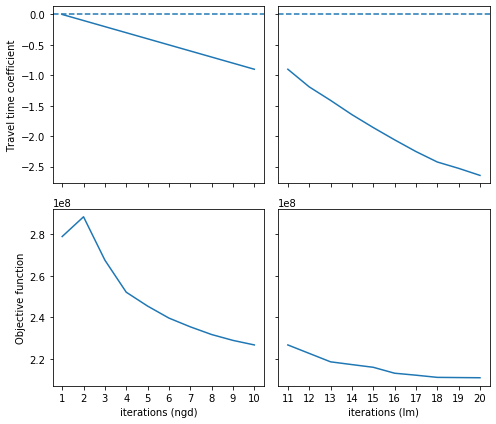

In [24]:
results_traveltime_model_df = isl.descriptive_statistics \
    .get_loss_and_estimates_over_iterations(results_norefined=learning_results_norefined_traveltime_model
                                            , results_refined=learning_results_refined_traveltime_model)

fig = isl.visualization.Artist().convergence(
    results_norefined_df=results_traveltime_model_df[results_traveltime_model_df['stage'] == 'norefined'],
    results_refined_df=results_traveltime_model_df[results_traveltime_model_df['stage'] == 'refined'],
    filename='convergence_' + fresno_network.key,
    methods=[outer_optimizer_norefined.method.key, outer_optimizer_refined.method.key],
    folder = estimation_reporter.dirs['estimation_folder'],
    simulated_data = False
)

##### Distribution of errors across link counts

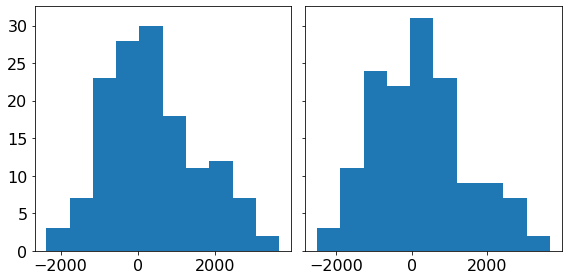

In [25]:
best_predicted_counts_norefined = np.array(list(learning_results_norefined_traveltime_model[best_iter_norefined_traveltime_model]['x'].values()))[:, np.newaxis]
best_predicted_counts_refined = np.array(list(learning_results_refined_traveltime_model[best_iter_refined_traveltime_model]['x'].values()))[:, np.newaxis]

fig, axs = plt.subplots(1, 2, sharey='all', tight_layout=True, figsize=(8, 4))

axs[0].hist(isl.estimation.error_by_link(observed_counts=np.array(list(counts.values()))[:, np.newaxis],
                                         predicted_counts=best_predicted_counts_norefined))
axs[1].hist(isl.estimation.error_by_link(observed_counts=np.array(list(counts.values()))[:, np.newaxis],
                                         predicted_counts=best_predicted_counts_refined))

for axi in [axs[0], axs[1]]:
    axi.tick_params(axis='x', labelsize=16)
    axi.tick_params(axis='y', labelsize=16)

plt.show()

fig.savefig(estimation_reporter.dirs['estimation_folder'] + '/' + 'distribution_predicted_error_counts.pdf',
            pad_inches=0.1, bbox_inches="tight")

### c) Model with all features

In [26]:
utility_function_full_model = isl.estimation.UtilityFunction(
    features_Y=['tt'],
#    features_Z= ['incidents'],
    features_Z= ['incidents', 'tt_cv','median_inc', 'bus_stops', 'intersections'],
    # initial_values = {'median_inc': 1.5, 'bus_stops':0},
    signs = {'tt': '-', 'tt_cv':'-', 'incidents':'-', 'intersections':'-', 'bus_stops':'-', 'median_inc':'+'},
    fixed = {'tt': True}
)

# Update utility functions of no refined and refined learners
learner_norefined.utility_function = utility_function_full_model
learner_refined.utility_function = utility_function_full_model

#Initialize value with the estimate obtained from b)
learner_norefined.utility_function.initial_values = theta_refined_traveltime_model
# learner_norefined.utility_function.zero_initializer()

paths_generator.read_paths(network=fresno_network, update_incidence_matrices=True,
                           filename = 'paths-traveltime-model-Fresno.csv',
                           folderpath = isl.config.dirs['write_network_data'] + 'paths/'
                           )

Progress: |###-----------------| 15.9% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |#######-------------| 34.3% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20668 paths were read in 18.4[s]          
20668 paths were loaded in the network
Updating incidence matrices
Matrix D (2413, 20668) generated in 32.2[s]
Progress(M): |########------------| 41.5% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress(M): |###################-| 95.8% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Matrix C (20668, 20668) generated in 3.0[s]


#### No refined stage

In [27]:
learning_results_norefined_full_model, inference_results_norefined_full_model, best_iter_norefined_full_model = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True,
                                            parameters_constraints = {'fixed': True, 'sign': True})

theta_norefined_full_model = learning_results_norefined_full_model[best_iter_norefined_full_model]['theta']

paths_generator.write_paths(network=fresno_network, overwrite_input=False, filename = 'paths-full-model-Fresno.csv')


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-2.6E+00', 'incidents': '0.0E+00', 'tt_cv': '0.0E+00', 'median_inc': '0.0E+00', 'bus_stops': '0.0E+00', 'intersections': '0.0E+00'}

SUE via fw (max iters: 100)
Path size correction with factor 1

Equilibrium gaps: ['2E-03', '0E+00']
Initial Fisk Objective: -251,807.08
Final Fisk Objective: -243,635.32
Improvement Fisk Objective: 3.25%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 106.5 [s]
Initial objective: 210,983,525
Initial RMSE: 1223.2
Initial Normalized RMSE: 0.553

Iteration : 2/10

Estimating parameters via ngd (1 iters, eta = 1.0E-01)

theta: {'tt': '-2.6E+00', 'incidents': '-1.1E-02', 'tt_cv': '0.0E+00', 'median_inc': '7.2E-02', 'bus_stops': '0.0E+00', 'intersections': '0.0E+00'}
time: 363.0[s]

SUE via fw (max iters: 100)

Column generation: 12 paths per od, 10.0% od coverage, demand sampling
26 paths added/replaced among 24 ods (New total paths: 20694)
Path size correction with factor 1

Equil

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20855 paths were written in 18.0[s]                 


#### Refined stage

In [28]:
features_Y,features_Z = isl.estimation.feature_selection(utility_function_full_model,
                                                          theta = theta_norefined_full_model,
                                                          criterion = 'sign')

utility_function_full_model = isl.estimation.UtilityFunction(
    features_Y = features_Y,
    features_Z = features_Z,
    fixed = {'tt': True}
)

learner_norefined.utility_function = utility_function_full_model
learner_refined.utility_function = utility_function_full_model

learner_refined.utility_function.initial_values = theta_norefined_full_model

learning_results_refined_full_model, inference_results_refined_full_model, best_iter_refined_full_model = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True,
                                            parameters_constraints = {'fixed': False, 'sign': False})

theta_refined_full_model = learning_results_refined_full_model[best_iter_refined_full_model]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-2.6E+00', 'incidents': '-3.5E-02', 'median_inc': '2.9E-01'}

SUE via fw (max iters: 100)
Path size correction with factor 1

Equilibrium gaps: ['1E-03', '2E-05']
Initial Fisk Objective: -80,030.56
Final Fisk Objective: -72,407.81
Improvement Fisk Objective: 9.52%
Final gap: 2E-05. Acc. bound: 1E-04. Time: 108.1 [s]
Initial objective: 209,572,987
Initial RMSE: 1219.2
Initial Normalized RMSE: 0.551

Iteration : 2/10

Estimating parameters via lm (1 iters)

Damping factors: ['1.0E-02']
theta: {'tt': '-3.3E+00', 'incidents': '-2.6E+00', 'median_inc': '1.8E+00'}
time: 210.8[s]

SUE via fw (max iters: 100)

Column generation: 12 paths per od, 10.0% od coverage, demand sampling
452 paths added/replaced among 362 ods (New total paths: 21307)
Path size correction with factor 1

Equilibrium gaps: ['8E-03', '2E-03', '4E-03', '0E+00']
Initial Fisk Objective: 758,086.61
Final Fisk Objective: 853,253.8
Improvement F

#### Report

In [29]:
estimation_reporter.add_items_report(
    selected_date = data_reader.options['selected_date'],
    selected_hour = data_reader.options['selected_hour'],
    selected_od_periods = data_reader.options['od_periods'],
    mean_counts=round(mean_count_benchmark_model,1),
    mean_counts_prediction_loss = round(mean_counts_prediction_loss,1),
    equilikely_prediction_loss = round(equilikely_prediction_loss,1)
)

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined_full_model,
    theta_refined= theta_refined_full_model,
    best_objective_norefined = round(learning_results_norefined_full_model[best_iter_norefined_full_model]['objective'],1),
    best_objective_refined = round(learning_results_refined_full_model[best_iter_refined_full_model]['objective'],1),
)

estimation_reporter.write_estimation_report(
    network=fresno_network,
    learners=[learner_norefined, learner_refined],
    utility_function=utility_function_full_model)

estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined_full_model,
    results_refined=learning_results_refined_full_model,
    network = fresno_network,
    utility_function = utility_function_full_model)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined_full_model,
    results_refined=inference_results_refined_full_model,
    float_format = '%.3f')

#### Visualization

In [ ]:
results_full_model_df = isl.descriptive_statistics \
    .get_loss_and_estimates_over_iterations(results_norefined=learning_results_norefined_full_model,
                                            results_refined=learning_results_refined_full_model)


# Convergence with curves for each parameter and comparing the travel time and full models
fig = isl.visualization.Artist().convergence_models(
    results_dfs={'traveltime_model': results_traveltime_model_df, 'full_model': results_full_model_df},
    features= {'tt': 'travel time', 'tt_cv':'coeficient of variation of travel time', 'incidents':'incidents', 'intersections':'intersections', 'bus_stops':'bus_stops', 'median_inc':'median income area'},
    filename='convergence_traveltime_and_full_models_' + fresno_network.key,
    folder=estimation_reporter.dirs['estimation_folder']
)

### d) Model with feature engineering

In [30]:
utility_function_feature_engineering_model = isl.estimation.UtilityFunction(
    features_Y=['tt'],
    features_Z= ['tt_sd_asj', 'no_incidents', 'no_bus_stops', 'no_intersections', 'low_inc'],
    signs = {'tt': '-', 'tt_sd_adj':'-', 'no_incidents':'+', 'no_bus_stops':'+', 'no_intersections':'+', 'low_inc':'-'},
    fixed = {'tt': True}
)

# Update utility functions of no refined and refined learners
learner_norefined.utility_function = utility_function_feature_engineering_model
learner_refined.utility_function = utility_function_feature_engineering_model

#Initialize travel time estimate with the one obtained from b) and load those paths as well
learner_norefined.utility_function.initial_values = theta_refined_traveltime_model

paths_generator.read_paths(network=fresno_network, update_incidence_matrices=True,
                           filename = 'paths-traveltime-model-Fresno.csv',
                           folderpath = isl.config.dirs['write_network_data'] + 'paths/'
                           )

# learner_norefined.outer_optimizer.method.eta = 5e-1
# learner_refined.outer_optimizer.method.eta = 5e-1

estimation_reporter = isl.writer.Reporter(folderpath = isl.config.dirs['output_folder'] + 'estimations/' + network_name, seed =_SEED)

Progress: |###-----------------| 15.9% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |#######-------------| 35.7% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |###########---------| 54.6% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20668 paths were read in 16.8[s]          
20668 paths were loaded in the network
Updating incidence matrices
Matrix D (2413, 20668) generated in 31.2[s]
Progress(M): |########------------| 40.8% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress(M): |###################-| 95.8% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Matrix C (20668, 20668) generated in 3.3[s]


#### No refined stage

In [31]:
learning_results_norefined_feature_engineering_model, inference_results_norefined_feature_engineering_model, best_iter_norefined_feature_engineering_model = \
    learner_norefined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True,
                            parameters_constraints = {'fixed': True, 'sign': True})

theta_norefined_feature_engineering_model = learning_results_norefined_feature_engineering_model[best_iter_norefined_feature_engineering_model]['theta']

paths_generator.write_paths(network=fresno_network, overwrite_input=False, filename = 'paths-feature-engineering-model-Fresno.csv')


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-2.6E+00', 'tt_cv': '0.0E+00', 'no_incidents': '0.0E+00', 'no_bus_stops': '0.0E+00', 'no_intersections': '0.0E+00', 'low_inc': '0.0E+00'}

SUE via fw (max iters: 100)
Path size correction with factor 1

Equilibrium gaps: ['2E-03', '0E+00']
Initial Fisk Objective: -251,807.08
Final Fisk Objective: -243,635.32
Improvement Fisk Objective: 3.25%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 106.6 [s]
Initial objective: 210,983,525
Initial RMSE: 1223.2
Initial Normalized RMSE: 0.553

Iteration : 2/10

Estimating parameters via ngd (1 iters, eta = 1.0E-01)

theta: {'tt': '-2.6E+00', 'tt_cv': '1.6E-02', 'no_incidents': '7.2E-02', 'no_bus_stops': '6.0E-02', 'no_intersections': '1.3E-02', 'low_inc': '2.8E-02'}
time: 339.3[s]

SUE via fw (max iters: 100)

Column generation: 12 paths per od, 10.0% od coverage, demand sampling
51 paths added/replaced among 48 ods (New total paths: 20719)
Path size correction with fact

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress (paths): |########------------| 37.6% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20889 paths were written in 17.1[s]                 


#### Refined stage

In [32]:
features_Y,features_Z = isl.estimation.feature_selection(utility_function_feature_engineering_model,
                                                          theta = theta_norefined_feature_engineering_model,
                                                          criterion = 'sign')

utility_function_feature_engineering_model = isl.estimation.UtilityFunction(
    features_Y = features_Y,
    features_Z = features_Z
)

learner_norefined.utility_function = utility_function_feature_engineering_model
learner_refined.utility_function = utility_function_feature_engineering_model

learner_refined.utility_function.initial_values = theta_norefined_feature_engineering_model

learning_results_refined_feature_engineering_model, inference_results_refined_feature_engineering_model, best_iter_refined_feature_engineering_model = \
    learner_refined.statistical_inference(h0=0, bilevel_iters=10, alpha=0.05, link_report=False, iteration_report = True,
                                          parameters_constraints = {'fixed': False, 'sign': False})

theta_refined_feature_engineering_model = learning_results_refined_feature_engineering_model[best_iter_refined_feature_engineering_model]['theta']


Bilevel optimization for Fresno network 

Iteration : 1/10

Initial theta: {'tt': '-2.7E+00', 'no_incidents': '2.7E-01', 'no_bus_stops': '8.5E-02'}

SUE via fw (max iters: 100)
Path size correction with factor 1

Equilibrium gaps: ['6E-03', '1E-03', '3E-04', '1E-04', '5E-05']
Initial Fisk Objective: 354,513.34
Final Fisk Objective: 398,802.18
Improvement Fisk Objective: 12.49%
Final gap: 5E-05. Acc. bound: 1E-04. Time: 183.6 [s]
Initial objective: 198,893,940
Initial RMSE: 1187.7
Initial Normalized RMSE: 0.537

Iteration : 2/10

Estimating parameters via lm (1 iters)

Damping factors: ['1.0E-02']
theta: {'tt': '-4.8E+00', 'no_incidents': '6.0E-01', 'no_bus_stops': '9.0E-02'}
time: 189.3[s]

SUE via fw (max iters: 100)

Column generation: 12 paths per od, 10.0% od coverage, demand sampling
44 paths added/replaced among 43 ods (New total paths: 20933)
Path size correction with factor 1

Equilibrium gaps: ['2E-03', '8E-05']
Initial Fisk Objective: 868,032.64
Final Fisk Objective: 964,235

#### Report

In [33]:
estimation_reporter.add_items_report(
    selected_date = data_reader.options['selected_date'],
    selected_hour = data_reader.options['selected_hour'],
    selected_od_periods = data_reader.options['od_periods'],
    mean_counts=round(mean_count_benchmark_model,1),
    mean_counts_prediction_loss = round(mean_counts_prediction_loss,1),
    equilikely_prediction_loss = round(equilikely_prediction_loss,1)
)

estimation_reporter.add_items_report(
    theta_norefined=theta_norefined_feature_engineering_model,
    theta_refined= theta_refined_feature_engineering_model,
    best_objective_norefined = round(learning_results_norefined_feature_engineering_model[best_iter_norefined_feature_engineering_model]['objective'],1),
    best_objective_refined = round(learning_results_refined_feature_engineering_model[best_iter_refined_feature_engineering_model]['objective'],1),
)

estimation_reporter.write_estimation_report(
    network=fresno_network,
    learners=[learner_norefined, learner_refined],
    utility_function=utility_function_feature_engineering_model)

estimation_reporter.write_learning_tables(
    results_norefined=learning_results_norefined_feature_engineering_model,
    results_refined=learning_results_refined_feature_engineering_model,
    network = fresno_network,
    utility_function = utility_function_feature_engineering_model)

estimation_reporter.write_inference_tables(
    results_norefined=inference_results_norefined_feature_engineering_model,
    results_refined=inference_results_refined_feature_engineering_model,
    float_format = '%.3f')

#### Visualization

In [ ]:
results_feature_engineering_model_df = isl.descriptive_statistics \
    .get_loss_and_estimates_over_iterations(results_norefined=learning_results_norefined_feature_engineering_model,
                                            results_refined=learning_results_refined_feature_engineering_model)


# Convergence with curves for each parameter and comparing the travel time and full models
fig = isl.visualization.Artist().convergence_models(
    results_dfs={'traveltime_model': results_traveltime_model_df, 'full_model': results_feature_engineering_model_df},
    features= {'tt': 'travel time', 'tt_sd_adj':'adjusted std of travel time', 'no_incidents':'no incidents', 'no_intersections':'no intersections', 'no_bus_stops':'no bus_stops', 'low_inc':'low income area'},
    filename='convergence_traveltime_and_full_models_' + fresno_network.key,
    folder=estimation_reporter.dirs['estimation_folder']
)